In [ ]:
#@title Copyright 2020-2023 Alina Wróblewska { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tagowanie

## CHANGELOG
09.05.2023 zmiany:

* Upgrade wersji Morfeusza
*   Integracja COMBO z narzędziem do segmentacji LAMBO


20.04.2021 zmiany zostały oznaczone:


*   OUTDATED: nieaktualne informacje
*   UPDATE: aktualne modyfikacje



In [ ]:
# W folerze 'zasoby' będą pobrane zasoby, tzn. dane, modele, 
# a do pozostałych folderów będą wpisywane predykcje.
import os
os.makedirs('zasoby', exist_ok=True)
os.makedirs('predykcje', exist_ok=True)
os.makedirs('predykcje/segmentatacja_gold', exist_ok=True)

In [2]:
! python --version

Python 3.10.11


### UPDATE_02: Instalacje

1. Obecna wersja COMBO jest kompatybilna z wersjami Pythona do 3.9. Ponieważ w google colab jest Python 3.10, to należy użyć zastępczej wersji środowiska wykonawczego, ustawiając:

**Tools -> Command palette -> Use fallback runtime version**

2. Aktualną wersję COMBO, która jest kompatybilna z narzędziem do segmentacji tekstu LAMBO, należy instalować ze źródła.

3. Dodano instalację [LAMBO](https://gitlab.clarin-pl.eu/syntactic-tools/lambo).

In [1]:
! python --version

Python 3.9.16


### ~~UPDATE! Instalacja COMBO~~


In [ ]:
# Instalacja COMBO
#!pip install -U pip setuptools wheel
#!pip install --index-url https://pypi.clarin-pl.eu/simple combo==1.0.3

## Przetwarzania plików CoNLL-U


Format CoNLL-U:
*   każdemu segmentowi odpowiada jedna linia,
*   zdania oddzielone są pustymi liniami,
*   każde zdanie poprzedzone jest metadanymi zapisanymi w liniach rozpoczynających się znakiem `#`,
*   w przypadku segmentów składających się z kilku wyrazów (np. im --> in dem w niemieckim) występuje dodatkowa linia odpowiadająca temu słowu,
*   linia zawierająca opis pojedynczego segmentu składa się z 10 kolumn:
 1.   ID: numer kolejny słowa w zdaniu,
 2.   ORTH: forma tekstowa,
 3.   **LEMMA**: lemat,
 4. **UPOS**: [uniwersalna część mowy](https://universaldependencies.org/u/pos/index.html),
 5. **XPOS**: tag właściwy dla danego języka,
 6. **UFEATS**: [uniwersalne cechy morfologiczne](https://universaldependencies.org/u/feat/index.html),
 7. HEAD: id nadrzędnika,
 8. DEPREL: etykieta relacji zależnościowej.

Do przetwarzania/zwracania plików w formacie CoNLL-U wykorzystamy bibliotekę [spacy-conll](https://pypi.org/project/spacy-conll/).

In [ ]:
# UPDATE! COMBO instaluje tę wersję spaCy, więc ten krok nie jest już konieczny
#!pip install spacy==2.3.2

In [ ]:
# Pobranie podstawowego modelu spaCy
!python -m spacy download en_core_web_sm-2.3.1 --direct

In [ ]:
# Wczytanie modelu podstawowego spaCy
import spacy
nlp = spacy.load("pl_core_news_sm-2.3.1")

In [ ]:
# Przetworzenie zdania
doc = nlp("To jest słoń, którego sfotografowaliśmy.")

In [ ]:
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
To                   to                   VERB                
jest                 być                  VERB                
słoń                 słoń                 NOUN                
,                    ,                    PUNCT               
którego              który                ADJ                 
sfotografowaliśmy    sfotografować        VERB                
.                    .                    PUNCT               


In [ ]:
doc = nlp("Tośmy sfotografowali słonia!")
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
Tośmy                tośmy                NOUN                
sfotografowali       sfotografować        VERB                
słonia               słoń                 NOUN                
!                    !                    PUNCT               


In [ ]:
# Instalacja biblioteki spacy-conll do przetwarzania plików conll
! pip install spacy-conll

Biblioteka ```spacy-conll``` umożliwia przetwarzanie wstępnie posegmentowanych plików:

Funkcja ```init_parser``` do inicjowania parsera akceptuje wstępnie posegmentowane wejście (```is_tokenized=True```)

In [ ]:
from spacy_conll import init_parser
nlp = init_parser('spacy', 'pl_core_news_sm', is_tokenized=True)

In [ ]:
doc = nlp('To jest słoń , którego sfotografowali śmy .')

In [ ]:
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
To                   to                   VERB                
jest                 być                  VERB                
słoń                 słoń                 NOUN                
,                    ,                    PUNCT               
którego              który                ADJ                 
sfotografowali       sfotografować        VERB                
śmy                  być                  AUX                 
.                    .                    PUNCT               


In [ ]:
doc = nlp('To śmy sfotografowali słonia !')
print("{:20} {:20} {:20}".format('SEGMENT', 'LEMAT', 'UPOS'))
for token in doc:
    print("{:20} {:20} {:20}".format(token.text, token.lemma_, token.pos_))

SEGMENT              LEMAT                UPOS                
To                   to                   PART                
śmy                  być                  AUX                 
sfotografowali       sfotografować        VERB                
słonia               słoń                 NOUN                
!                    !                    PUNCT               


Przy pomocy skryptu uruchamianego z wiersza poleceń ```parse-as-conll``` można przetworzyć string albo plik tekstowy i wpisać wynik do pliku CoNLL.

In [ ]:
!parse-as-conll --model_or_lang 'pl_core_news_sm' --input_str 'To jest słoń, którego sfotografowaliśmy.' --output_file 'test.conllu' --include_headers

In [ ]:
! head test.conllu

# sent_id = 1
# text = To jest słoń, którego sfotografowaliśmy.
1	To	to	VERB	PRED	_	0	ROOT	_	_
2	jest	być	VERB	FIN	_	1	aux	_	_
3	słoń	słoń	NOUN	SUBST	_	1	nsubj	_	SpaceAfter=No
4	,	,	PUNCT	INTERP	_	6	punct	_	_
5	którego	który	ADJ	ADJ	_	6	obj	_	_
6	sfotografowaliśmy	sfotografować	VERB	PRAET	_	3	acl	_	SpaceAfter=No
7	.	.	PUNCT	INTERP	_	1	punct	_	SpaceAfter=No


In [ ]:
! wget -P zasoby http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.txt

--2023-05-09 13:41:14--  http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.txt
Resolving mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)... 213.135.36.148
Connecting to mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)|213.135.36.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208260 (203K) [text/plain]
Saving to: ‘zasoby/PDBUD_test.txt’

PDBUD_test.txt      100%[===================>] 203.38K   228KB/s    in 0.9s    

2023-05-09 13:41:16 (228 KB/s) - ‘zasoby/PDBUD_test.txt’ saved [208260/208260]



In [ ]:
!head -n 10 zasoby/PDBUD_test.txt

Mężczyzna w czapce kuca na chodniku pod ścianą budynku, a koło niego jest pięć kotów.
Chłopak biegnie, asekurując jadącego obok rowerem chłopca w kasku na głowie.
Kilkanaście dziewczynek w białych sukienkach i kokardach na głowie stoi obok siebie na scenie.
Uśmiechnięta dziewczynka o jasnych włosach zjeżdża na zjeżdżalni.
Jasnowłose dziecko jedzie po chodniku na czerwonej hulajnodze.
Brudny samochód terenowy stoi zapadnięty w błocie.
Dwaj mężczyźni z wędkami stoją na plaży w pobliżu łodzi.
Dwie osoby skaczą nad śniegiem na deskach snowboardowych w pobliżu drewnianych budynków.
Małpa stoi zwrócona w kierunku innej skaczącej w jej stronę małpy.
Na boisku trzech piłkarzy podskakuje do piłki podczas meczu.


In [ ]:
! time parse-as-conll --model_or_lang 'pl_core_news_sm' --input_file 'zasoby/PDBUD_test.txt' --output_file 'predykcje/PDBUD_test_spaCy_baseline.conllu' --include_headers


real	0m18.370s
user	0m16.961s
sys	0m1.480s


In [ ]:
! tail -n 50 predykcje/PDBUD_test_spaCy_baseline.conllu

2	się	się	PART	QUB	_	1	expl:pv	_	SpaceAfter=No
3	,	,	PUNCT	INTERP	_	5	punct	_	_
4	że	że	SCONJ	COMP	_	5	mark	_	_
5	przemówił	przemówić	VERB	PRAET	_	1	ccomp	_	_
6	tu	tu	ADV	ADV	_	5	advmod	_	_
7	dziś	dziś	ADV	ADV	_	8	advmod	_	_
8	prawdziwy	prawdziwy	ADJ	ADJ	_	10	amod	_	_
9	socjaldemokratyczny	socjaldemokratyczny	ADJ	ADJ	_	10	amod	_	_
10	szef	szef	NOUN	SUBST	_	5	nsubj	_	_
11	rządu	rząd	NOUN	SUBST	_	10	nmod	_	SpaceAfter=No
12	.	.	PUNCT	INTERP	_	1	punct	_	SpaceAfter=No

# sent_id = 2415
# text = Chciałbym podziękować swojemu oponentowi, panu Bushill-Matthewsowi za profesjonalny sposób przewodniczenia negocjacjom, koleżankom i kolegom z innych grup za ich pomoc pod względem politycznym, a prezydencji francuskiej za jej wyrafinowane podejście.
1	Chciałbym	chciałbym	ADJ	ADJ	_	0	ROOT	_	_
2	podziękować	podziękować	VERB	INF	_	1	xcomp	_	_
3	swojemu	swój	ADJ	ADJ	_	4	amod	_	_
4	oponentowi	oponent	NOUN	SUBST	_	2	obj	_	SpaceAfter=No
5	,	,	PUNCT	INTERP	_	7	punct	_	_
6	panu	pan	NOUN	SUBST	_	7	nsubj	_	_
7

# Analizator morfologiczny [Morfeusz](http://morfeusz.sgjp.pl) w Pythonie
*   analizator i generator morfologiczny opracowany w IPI PAN
*   wersja demo: http://morfeusz.sgjp.pl/demo
*   można go wbudować w tworzone programy
*   przy pomocy dodatkowych modułów można go użyć z poziomu Pythona i Javy
*   dystrybuowany z dwoma słownikami: SGJP lub Polimorf
*   Tutorial Morfeusza (K. Krasnowska-Kieraś): http://clarin-pl.eu/wp-content/uploads/2019/10/Morfeusz2.pdf



### Instalacja
Instalujemy bibliotekę pythonową Morfeusza z pakietów Ubuntu ([instalacja dla innych systemów](http://morfeusz.sgjp.pl/download/))

In [ ]:
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install libmorfeusz2
!sudo apt install python3-morfeusz2
#!wget http://download.sgjp.pl/morfeusz/20230423/Linux/22.04/64/morfeusz2-1.99.6-20230423-cp310.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl -O morfeusz2-1.99.6-20230423-cp310.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl
!wget http://download.sgjp.pl/morfeusz/20220731/Linux/20.04/64/morfeusz2-1.99.5-20220731-cp310.cp35.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl -O morfeusz2-1.99.5-20220731-cp310.cp35.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl
#!python3 -m pip install --upgrade --force-reinstall morfeusz2-1.99.6-20230423-cp310.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl
!python3 -m pip install --upgrade --force-reinstall morfeusz2-1.99.5-20220731-cp310.cp35.cp36.cp37.cp38.cp39-abi3-linux_x86_64.whl

--2023-05-09 14:14:02--  http://download.sgjp.pl/apt/sgjp.gpg.key
Resolving download.sgjp.pl (download.sgjp.pl)... 193.0.67.154
Connecting to download.sgjp.pl (download.sgjp.pl)|193.0.67.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/pgp-keys]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.00K  --.-KB/s    in 0s      

2023-05-09 14:14:03 (197 MB/s) - written to stdout [1029/1029]

OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://download.sgjp.pl/apt/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/c

### Klasa `Morfeusz`
Biblioteka `morfeusz2` udostępnia klasę `Morfeusz` implementującą analizator i generator morfologiczny ([dokumentacja](http://sgjp.pl/morfeusz/download/Morfeusz2.pdf)).

In [ ]:
import morfeusz2
m = morfeusz2.Morfeusz()

### Analiza morfologiczna

In [ ]:
for a in m.analyse('Kolo pojechał na wakacje do Włoch autostopem.'):
    print(a)

(0, 1, ('Kolo', 'kolo', 'subst:sg:nom:m1', ['nazwa_pospolita'], ['pot.']))
(0, 1, ('Kolo', 'kolo', 'subst:sg:voc:m1', ['nazwa_pospolita'], ['pot.']))
(0, 1, ('Kolo', 'Kolo:Sf', 'subst:sg.pl:nom.gen.dat.acc.inst.loc.voc:f', ['nazwisko'], []))
(0, 1, ('Kolo', 'Kolo:Sm1', 'subst:sg:nom:m1', ['nazwisko'], []))
(0, 1, ('Kolo', 'Kolo:Sm1', 'subst:sg:voc:m1', ['nazwisko'], []))
(0, 1, ('Kolo', 'kola', 'subst:sg:voc:f', ['nazwa_pospolita'], []))
(1, 2, ('pojechał', 'pojechać', 'praet:sg:m1.m2.m3:perf', [], []))
(2, 3, ('na', 'na:I', 'interj', [], []))
(2, 3, ('na', 'na:P', 'prep:acc', [], []))
(2, 3, ('na', 'na:P', 'prep:loc', [], []))
(3, 4, ('wakacje', 'wakacje', 'subst:pl:nom.acc.voc:n:pt', ['nazwa_pospolita'], []))
(4, 5, ('do', 'do:S', 'subst:sg.pl:nom.gen.dat.acc.inst.loc.voc:n:ncol', ['nazwa_pospolita'], ['muz.']))
(4, 5, ('do', 'do:P', 'prep:gen', [], []))
(5, 6, ('Włoch', 'Włoch:Sf', 'subst:sg.pl:nom.gen.dat.acc.inst.loc.voc:f', ['nazwisko'], []))
(5, 6, ('Włoch', 'Włoch:Sm1~chowie', 

Graf analizy morfologicznej reprezentowany jest jako lista krotek (`tuple`) . Każda krotka zawiera:
 * indeks początku segmentu w grafie,
 * indeks końca segmentu w grafie,
 * interpretację morfologiczną (zagnieżdżoną krotkę):
   * formę tekstową,
   * lemat,
   * tag (znacznik morfologiczny),
   * kategorię nazw własnych,
   * listę kwalifikatorów stylistycznych i dziedzinowych.

Morfeusz domyślnie używa „spakowanej” notacji dla znaczników. Np. `praet:sg:m1.m2.m3:perf` należy odczytać jako skrót dla wszystkich kombinacji wartości oddzielonych kropkami na poszczególnych pozycjach:
  * `praet:sg:m1:perf`
  * `praet:sg:m2:perf`
  * `praet:sg:m3:perf`

### Generowanie morfologiczne

In [ ]:
print("Lista form wyrazowych lematu brat:")
for g in m.generate('brat'):
    print(g)

Lista form wyrazowych lematu brat:
('brat', 'brat', 'subst:sg:nom:m1', ['nazwa_pospolita'], [])
('brata', 'brat', 'subst:sg:gen.acc:m1', ['nazwa_pospolita'], [])
('bratu', 'brat', 'subst:sg:dat:m1', ['nazwa_pospolita'], [])
('bratem', 'brat', 'subst:sg:inst:m1', ['nazwa_pospolita'], [])
('bracie', 'brat', 'subst:sg:loc:m1', ['nazwa_pospolita'], [])
('bracie', 'brat', 'subst:sg:voc:m1', ['nazwa_pospolita'], [])
('bracia', 'brat', 'subst:pl:nom.voc:m1', ['nazwa_pospolita'], [])
('braci', 'brat', 'subst:pl:gen.acc:m1', ['nazwa_pospolita'], [])
('braciom', 'brat', 'subst:pl:dat:m1', ['nazwa_pospolita'], [])
('braćmi', 'brat', 'subst:pl:inst:m1', ['nazwa_pospolita'], [])
('braciach', 'brat', 'subst:pl:loc:m1', ['nazwa_pospolita'], [])
('b', 'brat', 'brev:pun', [], [])
('braty', 'brat', 'depr:pl:nom.acc.voc:m2', ['nazwa_pospolita'], [])


#  OUTDATED_02: ~~Model morfeuszowy spaCy dla polskiego~~

Ten model nie jest kompatybilny z Python 3.9



*   Wymaga zainstalowania biblioteki Morfeusz2
*   Tagi i lemmaty zwracane przez Morfeusza są ujednoznaczniane przez tager Toygger
*   Modele morfeuszowe spaCy dla polskiego dostępne są na http://zil.ipipan.waw.pl/SpacyPL
*   Notatnik z instruktarzem: https://nbviewer.jupyter.org/github/ipipan/spacy-pl/blob/master/spaCy_PL_morfeusz_demo.ipynb

### Instalacja

In [2]:
! wget -P zasoby http://mozart.ipipan.waw.pl/~alina/zasoby/data/pl_spacy_model_morfeusz-0.1.3.tar.gz

--2023-05-09 20:06:09--  http://mozart.ipipan.waw.pl/~alina/zasoby/data/pl_spacy_model_morfeusz-0.1.3.tar.gz
Resolving mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)... 213.135.36.148
Connecting to mozart.ipipan.waw.pl (mozart.ipipan.waw.pl)|213.135.36.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229068993 (218M) [application/x-gzip]
Saving to: ‘zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz’

pl_spacy_model_morf 100%[===================>] 218.46M  21.0MB/s    in 11s     

2023-05-09 20:06:20 (19.2 MB/s) - ‘zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz’ saved [229068993/229068993]



In [ ]:
! python -m pip install zasoby/pl_spacy_model_morfeusz-0.1.3.tar.gz

In [ ]:
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz

### Predykcja

In [ ]:
import spacy
nlp = spacy.load("pl_spacy_model_morfeusz")

In [ ]:
doc = nlp("To jest słoń, którego sfotografowaliśmy.")

In [ ]:
# Atrubuty tokenów https://spacy.io/api/token
print("{:15} {:15} {:15} {:15}".format('SEGMENT', 'LEMAT', 'UPOS', 'TAG'))
for token in doc:
    print("{:15} {:15} {:15} {:15}".format(token.text, token.lemma_, token.pos_, ':'.join([token.tag_, token._.feats]).rstrip(":")))

In [ ]:
doc2 = nlp("Tośmy sfotografowali słonia!")
print("{:15} {:15} {:15} {:15}".format('SEGMENT', 'LEMAT', 'UPOS', 'TAG'))
for token in doc2:
    print("{:15} {:15} {:15} {:15}".format(token.text, token.lemma_, token.pos_, ':'.join([token.tag_, token._.feats]).rstrip(":")))

In [ ]:
!parse-as-conll --model_or_lang 'pl_spacy_model_morfeusz' --input_file 'zasoby/PDBUD_test.txt' --output_file 'predykcje/PDBUD_test_spaCy_Morfeusz.conllu' --include_headers

In [ ]:
!head -n 50 predykcje/PDBUD_test_spaCy_Morfeusz.conllu

# COMBO


*  COMBO to niezależny od języka system wstępnego przetwarzania języka naturalnego, który wykorzystuje algorytmy sieci neuronowych.
*  Moduły COMBO:
 * tager (predykcja uniwersalnych części mowy i specyficznych dla języka tagów),
 * analizator morfologiczny (predykcja list cech gramatycznych), 
 * lematyzator (predykcja lematów),
 * parser zależnościowy (predykcja krawędzi w drzewie i etykiet, tj. typów relacji zależnościowych),
 * moduł etykietowania ról semantycznych (predykcja ról semantycznych, np. Time, Place, Recipient),
 * moduł obliczanie zanurzeń zdań (ang. sentence embeddings).
*  Repozytorium COMBO: https://gitlab.clarin-pl.eu/syntactic-tools/combo
*  Zalety COMBO:
 *  pakiet Pythonowy oparty na platformie AllenNLP i bibliotece PyTorch,
 *  umożliwia trenowanie modeli różniących się zakresem cech wejściowych, zakresem predykcji, rodzajem reprezentowania danych wejściowych (np. zanurzenia typu fastText, BERT),
 *  pozwala na trenowanie modeli na bankach drzew zależnościowych w formacie CoNLL (drzewa mogą być zaanotowane zgodnie ze schematem UD albo innym, specyficznym dla języka),
 *  system typu end-to-end z równocześnie trenowanymi modułami predykcyjnymi, dlatego trenowanie COMBO jest znacznie szybsze niż ,,potokowe” trenowanie systemów (np. Stanza).

### Instalacje COMBO i LAMBO

*   Lista dostępnych modeli jest tutaj https://gitlab.clarin-pl.eu/syntactic-tools/combo/-/blob/master/docs/performance.md
*   System COMBO jest ciągle udoskonalany. Najbardziej aktualnym źródłem informacji jest repozytorium projektowe COMBO https://gitlab.clarin-pl.eu/syntactic-tools/combo/
* LAMBO tokeniser  https://gitlab.clarin-pl.eu/syntactic-tools/lambo (Przybyła, 2022)



In [5]:
# Instalacja LAMBO
! git clone https://gitlab.clarin-pl.eu/syntactic-tools/lambo.git --depth 1
! pip install ./lambo

Cloning into 'lambo'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 60 (delta 5), reused 55 (delta 1), pack-reused 0
Unpacking objects: 100% (60/60), 82.69 KiB | 153.00 KiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./lambo
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 67.7 MB/s eta 0:00:00
  Created wheel for lambo: filename=lambo-2.0.0-py3-none

In [6]:
# Instalacja COMBO (uwaga, instalacja trwa dość długo)
! git clone https://gitlab.clarin-pl.eu/syntactic-tools/combo --depth 1

Cloning into 'combo'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 91 (delta 3), reused 56 (delta 0), pack-reused 0
Unpacking objects: 100% (91/91), 42.31 MiB | 2.80 MiB/s, done.


In [7]:
! pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [8]:
# Instalacja COMBO trwa kilkanaście minut na google colab
%cd combo
! pip install -e .

/content/combo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/combo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.9/506.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.7/255.7 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 8.0 MB/s eta 0:00:00
  Using cached spacy-2.3.2.tar.gz (5.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_learn-0.23.2-cp39-cp39-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.1 MB/s eta 0:00:00
     

In [9]:
!python -m spacy download en_core_web_sm-2.3.1 --direct

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz#egg=en_core_web_sm==2.3.1 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 139.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047102 sha256=36e6e3a12d4d2a826478fc44ad58e9ea80fb87bc7cae10a42d8a8d5863e64616
  Stored in directory: /tmp/pip-ephem-wheel-cache-ek7c_93q/wheels/19/d6/1c/5484b95647df5d7afaf74abde458c66c1cd427e69e801fe826
Successfully built en_core_web_sm
  Attempting uninstall: en_core_web_sm
    Found existin

## Uruchamianie COMBO

In [10]:
# UPDATE Import pakietu COMBO
from combo.predict import COMBO

### COMBO z wstępnie posegmentowanym tekstem

In [11]:
# Należy podać nazwę wybranego modelu.
# Jeśli nie ma GPU, to cuda_device=-1
# Model polish-herbert-base-ud29 jest wspomagany kontekstowymi zanurzeniami typu BERT
combo = COMBO.from_pretrained("polish-herbert-base-ud29", cuda_device=0)

100%|██████████| 319M/319M [00:16<00:00, 20.4MB/s]


In [12]:
sentence = combo([['Pierwsze', 'zdanie', 'do', 'przetworzenia', 'jest', 'najtrudniejsze', '.']])

In [16]:
print("{:4} {:15} {:15} {:8} {:22} {:8} {:10} {:20}".format('ID', 'TOKEN', 'LEMMA', 'UPOS', 'XPOS', 'HEAD', 'DEPREL', 'FEATS'))
for t in sentence[0].tokens:
    print("{:4} {:15} {:15} {:8} {:22} {:8} {:10} {:10}".format(str(t.id), t.token, t.lemma, t.upostag, t.xpostag, str(t.head), t.deprel, t.feats))

ID   TOKEN           LEMMA           UPOS     XPOS                   HEAD     DEPREL     FEATS               
1    Pierwsze        pierwszy        ADJ      adj:sg:nom:n:pos       2        amod       Case=Nom|Degree=Pos|Gender=Neut|Number=Sing
2    zdanie          zdanie          NOUN     subst:sg:nom:n:ncol    6        nsubj      Case=Nom|Gender=Neut|Number=Sing|Polarity=Pos
3    do              do              ADP      prep:gen               4        case       AdpType=Prep
4    przetworzenia   przetworzyć     NOUN     ger:sg:gen:n:perf:aff  2        nmod       Aspect=Perf|Case=Gen|Gender=Neut|Number=Sing|Polarity=Pos|VerbForm=Vnoun
5    jest            być             AUX      fin:sg:ter:imperf      6        cop        Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act
6    najtrudniejsze  trudny          ADJ      adj:sg:nom:n:sup       0        root       Case=Nom|Degree=Sup|Gender=Neut|Number=Sing
7    .               .               PUNCT    interp         

### COMBO z narzędziem do segmentacji LAMBO

In [17]:
from combo.utils import lambo
nlpre = COMBO.from_pretrained("polish-herbert-base-ud29",tokenizer=lambo.LamboTokenizer("pl"),cuda_device=0)

Using model LAMBO-UD_Polish-PDB


100%|██████████| 1.25k/1.25k [00:00<00:00, 620kB/s]
100%|██████████| 2.82M/2.82M [00:00<00:00, 3.25MB/s]
100%|██████████| 352k/352k [00:00<00:00, 920kB/s]


In [19]:
text_pl = "Holmes po raz pierwszy pojawił się w powieści Studium w szkarłacie, wydanej w 1887 roku. Łącznie Conan Doyle napisał 4 powieści (Studium w szkarłacie, Pies Baskerville'ów, Znak czterech, Dolina trwogi) i 56 opowiadań o Holmesie."

sents_pl = nlpre(text_pl)

In [20]:
for i, s in enumerate(sents_pl):
  print("Sentence {}: {}".format(i+1, " ".join([t.token for t in s.tokens])))
  print()
  print("{:5} {:15} {:15} {:10} {:10} {:10} {:10} {:20}".format('ID', 'TOKEN', 'LEMMA', 'UPOS', 'XPOS', 'HEAD', 'DEPREL', 'FEATS'))
  for t in s.tokens:
    print("{:5} {:15} {:15} {:10} {:10} {:10} {:10} {:10}".format(str(t.id), t.token, t.lemma, t.upostag, t.xpostag, str(t.head), t.deprel, t.feats))
  print()

Sentence 1: Holmes po raz pierwszy pojawił się w powieści Studium w szkarłacie , wydanej w 1887 roku .

ID    TOKEN           LEMMA           UPOS       XPOS       HEAD       DEPREL     FEATS               
1     Holmes          Holmes          PROPN      subst:sg:nom:m1 5          nsubj      Animacy=Hum|Case=Nom|Gender=Masc|Number=Sing
2     po              po              ADP        prep:acc   3          case       AdpType=Prep
3     raz             raz             NOUN       subst:sg:acc:m3 5          obl        Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing
4     pierwszy        pierwszy        ADJ        adj:sg:acc:m3:pos 3          amod       Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|Number=Sing
5     pojawił         pojawić         VERB       praet:sg:m1:perf 0          root       Animacy=Hum|Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act
6     się             się             PRON       part       5          expl:pv    PronType=Prs|Reflex=Yes
7 

Konsolowa wersja COMBO wymaga pobrania modelu COMBO

In [21]:
# model COMBO 
! wget -P zasoby http://s3.clarin-pl.eu/dspace/combo/ud_29/english-bert-base-ud29.tar.gz

--2023-05-09 21:00:12--  http://s3.clarin-pl.eu/dspace/combo/ud_29/english-bert-base-ud29.tar.gz
Resolving s3.clarin-pl.eu (s3.clarin-pl.eu)... 156.17.135.1
Connecting to s3.clarin-pl.eu (s3.clarin-pl.eu)|156.17.135.1|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3.clarin-pl.eu/dspace/combo/ud_29/english-bert-base-ud29.tar.gz [following]
--2023-05-09 21:00:13--  https://s3.clarin-pl.eu/dspace/combo/ud_29/english-bert-base-ud29.tar.gz
Connecting to s3.clarin-pl.eu (s3.clarin-pl.eu)|156.17.135.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447111559 (426M) [application/octet-stream]
Saving to: ‘zasoby/english-bert-base-ud29.tar.gz’

english-bert-base-u 100%[===================>] 426.40M  21.6MB/s    in 21s     

2023-05-09 21:00:34 (20.7 MB/s) - ‘zasoby/english-bert-base-ud29.tar.gz’ saved [447111559/447111559]



In [22]:
# korpus wzorcowy
!git clone https://github.com/UniversalDependencies/UD_English-EWT.git --depth 1

Cloning into 'UD_English-EWT'...
remote: Enumerating objects: 1204, done.
remote: Counting objects: 100% (1204/1204), done.
remote: Compressing objects: 100% (1151/1151), done.
remote: Total 1204 (delta 462), reused 151 (delta 51), pack-reused 0
Receiving objects: 100% (1204/1204), 6.93 MiB | 1.30 MiB/s, done.
Resolving deltas: 100% (462/462), done.


In [25]:
!combo --mode predict --model_path zasoby/english-bert-base-ud29.tar.gz --input_file UD_English-EWT/en_ewt-ud-test.conllu --output_file en_ewt-ud-test_predictions.conllu --silent

2023-05-09 21:01:47.559549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0509 21:01:51.445472 140460132345664 archival.py:184] loading archive file zasoby/english-bert-base-ud29.tar.gz
I0509 21:01:51.445884 140460132345664 archival.py:263] extracting archive file zasoby/english-bert-base-ud29.tar.gz to temp dir /tmp/tmpi3_1pio7
I0509 21:01:56.243575 140460132345664 params.py:248] dataset_reader.type = conllu
I0509 21:01:56.244234 140460132345664 params.py:248] dataset_reader.lazy = False
I0509 21:01:56.244425 140460132345664 params.py:248] dataset_reader.cache_directory = None
I0509 21:01:56.244549 140460132345664 params.py:248] dataset_reader.max_instances = None
I0509 21:01:56.244638 140460132345664 params.py:248] dataset_reader.manual_distributed_sharding = False
I0509 21:01:56.244714 140460132345664 params.py:248] dataset_reader.manual_multi_process_sharding = False
I0509 21:01:56.245108 140460132345664 params.py:248] dataset_read

In [26]:
! head -n 50 en_ewt-ud-test_predictions.conllu

# newdoc id = weblog-blogspot.com_zentelligence_20040423000200_ENG_20040423_000200
# sent_id = weblog-blogspot.com_zentelligence_20040423000200_ENG_20040423_000200-0001
# newpar id = weblog-blogspot.com_zentelligence_20040423000200_ENG_20040423_000200-p0001
# text = What if Google Morphed Into GoogleOS?
1	What	what	PRON	WP	PronType=Int	0	root	0:root	_
2	if	if	SCONJ	IN	_	4	mark	4:mark	_
3	Google	Google	PROPN	NNP	Number=Sing	4	nsubj	4:nsubj	_
4	Morphed	morphe	VERB	VBD	Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin	1	advcl	1:advcl:if	_
5	Into	into	ADP	IN	_	6	case	6:case	_
6	GoogleOS	Googleo	PROPN	NNP	Number=Sing	4	obl	4:obl:into	SpaceAfter=No
7	?	?	PUNCT	.	_	1	punct	4:punct	_

# sent_id = weblog-blogspot.com_zentelligence_20040423000200_ENG_20040423_000200-0002
# text = What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?
1	What	what	PRON	WP	PronType=Int	0	root	0:root	_
2	if	if	SCONJ	IN	_	4	mark	4:mark	_
3	Google	Google	PROPN	NNP

# Ewaluacja – miary

Skuteczność narzędzia NLP możne mierzyć kilkoma metrykami (miarami) używanymi w uczeniu maszynowym:
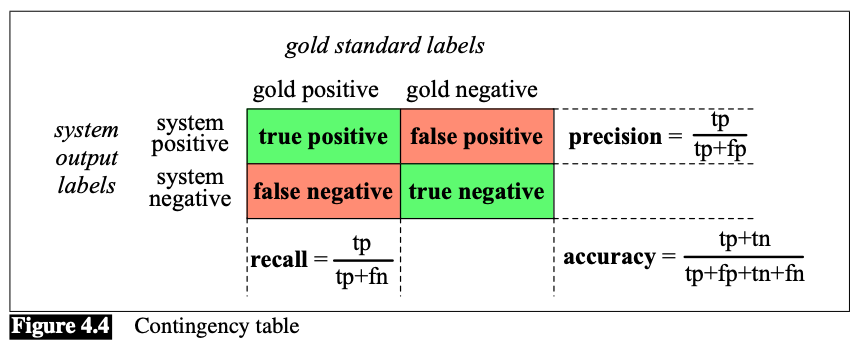

* $TP$: przykłady prawdziwie pozytywne,
* $FP$: przykłady fałszywie pozytywne,
* $FN$: przykłady fałszywie negatywne,
* $TN$: przykłady prawdziwie negatywne.


### Accuracy (dokładność)

Odsetek instancji, którym klasyfikator przypisał prawidłową kategorię.

$A = \frac{\mathit{TP+TN}}{\mathit{TP+FP+TN+FN}} = \frac{\mathit{\#correct}}{\mathit{\#total}}$


In [28]:
from sklearn.metrics import accuracy_score

print(accuracy_score([1, 2, 3, 2, 1], [1, 2, 3, 4, 5]))

0.6


### Precision, recall i F-mesure


**Precision** to ddsetek instancji wykrytych przez system, które są rzeczywiście poprawne.

$P = \frac{\mathit{TP}}{TP+FP}$

**Recall** to odsetek instancji w danych wejściowych, które zostały poprawnie zidentyfikowane przez system.

$R = \frac{\mathit{TP}}{TP+FN}$

**F(1)-measure** to średnia harmoniczna wartości precision i recall:

$F = \frac{2PR}{P + R}$


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_gold = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

for metric in (accuracy_score, precision_score, recall_score, f1_score):
    print('{:16} {:.2f}'.format(metric.__name__, metric(y_gold, y_pred)))

accuracy_score   0.80
precision_score  1.00
recall_score     0.50
f1_score         0.67


In [30]:
y_gold = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

for metric in (accuracy_score, precision_score, recall_score, f1_score):
    print('{:16} {:.2f}'.format(metric.__name__, metric(y_gold, y_pred)))

accuracy_score   0.70
precision_score  0.57
recall_score     1.00
f1_score         0.73


### Klasyfikacja wieloklasowa (*multiclass classification*)


#### Micro

Zliczamy $TP$, $FP$ i $FN$ globalnie dla wszystkich danych. W ten sposób każda instancja ma taki sam wpływ na wynik końcowy. Każdy przykład zaklasyfikowany niepoprawnie jest uznawany jednocześnie za $FP$ i $FN$.

$TP =\mathit{\#correct}$

$FP = FN = \mathit{\#total} - \mathit{\#correct}$

W efekcie precision, recall i F-measure w wersji micro są równe sobie nawzajem i mierze accuracy:

$P_{mic} = \frac{TP}{TP + FP} = \frac{\mathit{\#correct}}{\mathit{\#total}} = A$

$R_{mic} = \frac{TP}{TP + FN} = \frac{\mathit{\#correct}}{\mathit{\#total}} = A$

$F_{mic} = \frac{2 P_{mic}R_{mic}}{P_{mic}+R_{mic}} = \frac{2 A^2}{2A} = A$

In [31]:
y_gold = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
y_pred = [0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0]

print(accuracy_score(y_gold, y_pred))
print(precision_score(y_gold, y_pred, average="micro"))
print(recall_score(y_gold, y_pred, average="micro"))
print(f1_score(y_gold, y_pred, average="micro"))

0.5833333333333334
0.5833333333333334
0.5833333333333334
0.5833333333333334


#### Macro

Obliczamy miary precision, recall i F-measure dla każdej klasy osobno i obliczamy ich średnie (standardowo nieważone, możliwy jest również wariant ważony, aby zmniejszyć wpływ mniej reprezentowanych klas na wynik).

In [32]:
y_gold = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
y_pred = [0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0]

print(accuracy_score(y_gold, y_pred))
print(precision_score(y_gold, y_pred, average="macro"))
print(recall_score(y_gold, y_pred, average="macro"))
print(f1_score(y_gold, y_pred, average="macro"))

0.5833333333333334
0.611111111111111
0.5833333333333334
0.580952380952381


### Tablica pomyłek (ang. confusion matrix)

Macierz zliczająca, ile razy instancję klasy X zaklasyfikowano jako klasę Y. Wartości na przekątnej odpowiadają prawidłowym klasyfikacjom.

W przykładzie poniżej kolejne wiersze macierzy należy odczytywać następująco:
 * **3** razy zaklasyfikowano 0 jako 0, **1** raz zaklasyfikowano 0 jako 1, **0** razy zaklasyfikowano 0 jako 2;
 * **1** raz zaklasyfikowano 1 jako 0, **2** razy zaklasyfikowano 1 jako 1, **1** raz zaklasyfikowano 1 jako 2;
 * **2** razy zaklasyfikowano 2 jako 0, **1** raz zaklasyfikowano 2 jako 1, **1** raz zaklasyfikowano 2 jako 2;
 

In [33]:
from sklearn.metrics import confusion_matrix

y_gold = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]
y_pred = [0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1]

print(confusion_matrix(y_gold, y_pred))

[[3 1 0]
 [1 2 1]
 [2 1 1]]


## Zadanie 1: Ewaluacja tagerów
Zaimplementuj ewaluację wydajnościową (czas predykcji) oraz jakościową (wykorzystaj poznane miary ewaluacyjne) uniwersalnych tagów (UPOS) i lematów (LEMMA) zwróconych przez modele spaCy (pl_core_news_sm) i COMBO. Wykorzystaj wzorcowy zbiór testowy http://mozart.ipipan.waw.pl/~alina/zasoby/data/PDBUD_test.conllu. Ponieważ nie testujemy jakości segmentacji i nie chcemy, żeby błędna segmentacja miała wpływ na jakość predykcji tagów i lematów, to segmentacja zdań w plikach wejściowych powinna być zgodna z segmentacją PDBUD_test.conllu.

(nie testujemy modelu morfeuszowego spaCy, bo on nie akceptuje wstępnie posegmentowanego wejścia)